In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
finaldata = pd.read_csv('finaldata.csv',encoding = 'gbk')

In [3]:
finalX = finaldata.iloc[:,1:21]

In [4]:
y = finaldata.iloc[:,-1]

## 消除量纲

In [5]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(finalX)

## 处理样本不平衡

In [6]:
import imblearn
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=420)
X,y = sm.fit_sample(finalX,y)

## 切分数据集

In [7]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,y,test_size=0.3,random_state=2018)

## 模型分数和图表

In [8]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn import metrics

In [9]:
lr_model = LogisticRegressionCV(cv=5, max_iter=1000)
svm_model = SVC(class_weight='balanced', gamma='auto', probability=True)
dt_model = DecisionTreeClassifier(max_depth=4, random_state=2018)
rf_model = RandomForestClassifier(n_estimators=1000,max_depth=4, n_jobs=-1, oob_score=True, random_state=2018, verbose=1)
gbdt_model = GradientBoostingClassifier(n_estimators=1000)
xgb_model = XGBClassifier(n_estimators=1000)
lgb_model = lgb.LGBMClassifier(n_estimators=100)

models = {'LR': lr_model,
          'SVM': svm_model,
          'DT': dt_model,
          'RF': rf_model,
          'GBDT': gbdt_model,
          'XGBoost': xgb_model,
          'LightGBM': lgb_model}

In [10]:
def get_metric(clf, X, y_true):
    y_pred = clf.predict(X)
    y_proba = clf.predict_proba(X)

    acc = metrics.accuracy_score(y_true, y_pred)
    p = metrics.precision_score(y_true, y_pred)
    r = metrics.recall_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_proba[:, 1])
    auc = metrics.auc(fpr, tpr)
    return acc, p, r, f1, fpr, tpr, auc

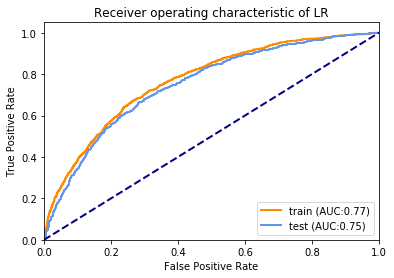

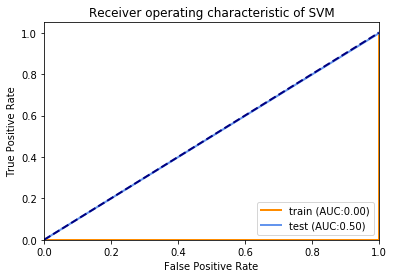

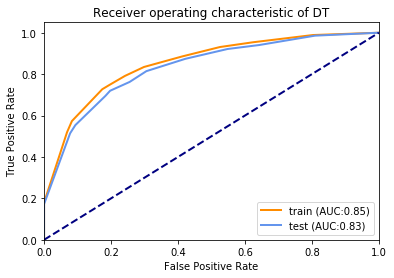

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s


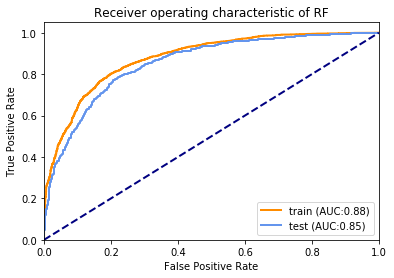

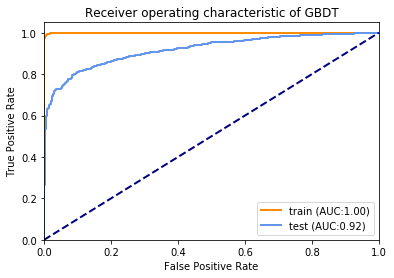

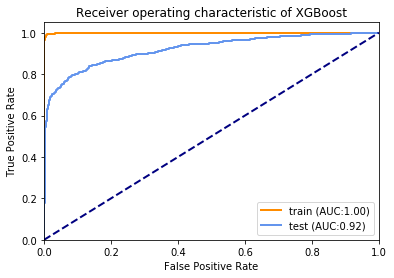

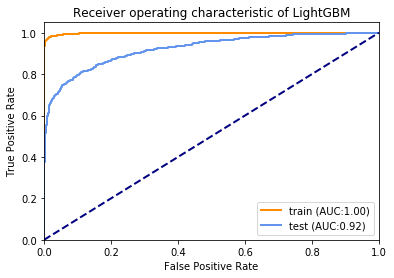

In [11]:
df_result = pd.DataFrame(columns=('Model', 'dataset', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC'))
row = 0
fprs_train = []
tprs_train = []
aucs_train = []
fprs_test = []
tprs_test = []
aucs_test = []
for name, clf in models.items():
    clf.fit(Xtrain, Ytrain)
    acc, p, r, f1, fpr_train, tpr_train, auc_train = get_metric(clf, Xtrain, Ytrain)
    fprs_train.append(fpr_train)
    tprs_train.append(tpr_train)
    aucs_train.append(auc_train)
    df_result.loc[row] = [name, 'train', acc, p, r, f1, auc_train]
    row += 1

    acc, p, r, f1, fpr_test, tpr_test, auc_test = get_metric(clf, Xtest, Ytest)
    fprs_test.append(fpr_test)
    tprs_test.append(tpr_test)
    aucs_test.append(auc_test)
    df_result.loc[row] = [' ', 'test', acc, p, r, f1, auc_test]
    row += 1

    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='darkorange', lw=lw, label='train (AUC:%0.2f)' % auc_train)
    plt.plot(fpr_test, tpr_test, color='cornflowerblue', lw=lw, label='test (AUC:%0.2f)' % auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic of '+name)
    plt.legend(loc="lower right")
    plt.show()

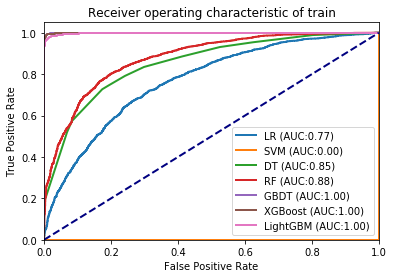

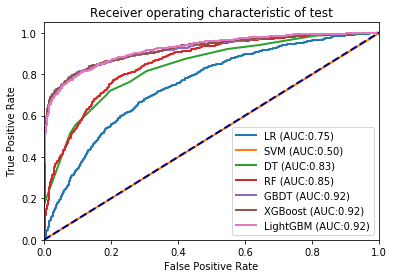

In [12]:
def plot_roc(fprs, tprs, aucs, title):
    plt.figure()
    lw = 2
    colors = ['deeppink', 'aqua', 'darkorange', 'cornflowerblue', '']
    for i, name in enumerate(models):
        plt.plot(fprs[i], tprs[i], lw=lw,
                 label='{0} (AUC:{1:0.2f})'.format(name, aucs[i]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic of '+title)
    plt.legend(loc="lower right")
    plt.show()

plot_roc(fprs_train, tprs_train, aucs_train, 'train')
plot_roc(fprs_test, tprs_test, aucs_test, 'test')

In [13]:
df_result

,Model,dataset,Accuracy,Precision,Recall,F1 score,AUC
0,LR,train,0.693497,0.729972,0.618857,0.669838,0.767658
1,,test,0.685393,0.712389,0.609848,0.657143,0.748530
2,SVM,train,1.000000,1.000000,1.000000,1.000000,0.000000
3,,test,0.494382,0.494382,1.000000,0.661654,0.498580
4,DT,train,0.776395,0.808530,0.727127,0.765671,0.851894
5,,test,0.756554,0.787554,0.695076,0.738431,0.833048
6,RF,train,0.800080,0.796537,0.808630,0.802538,0.878705
7,,test,0.778090,0.765027,0.795455,0.779944,0.853347
8,GBDT,train,0.988960,0.996753,0.981223,0.988927,0.999640
9,,test,0.850187,0.869478,0.820076,0.844055,0.918326
